In [3]:
%pylab inline
import tensorflow as tf
import sys
sys.path.insert(0, '../python')

Populating the interactive namespace from numpy and matplotlib


/local/home/fnammour/miniconda3/envs/TFgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:516: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/local/home/fnammour/miniconda3/envs/TFgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:517: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/local/home/fnammour/miniconda3/envs/TFgpu/lib/python3.7/site-packages/tensorflow/python/framework/dtypes.py:518: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/local/home/fnammour/m

# Step I: Reading data

In [4]:
from DeepDeconv.utils.batch_utils import dynamic_batches

In [5]:
#Input the directory containing the fits file
data_directory = '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/'
write_path = '/data/DeepDeconv/data/vsc_euclidpsfs/reshuffle/'

#Retrieves the list of all the files
import glob

# Galaxy images
gal_files = glob.glob(data_directory+'image-*-multihdu.fits')
gal_files.sort()

# Window images for the custom loss (see below)
win_files = glob.glob(data_directory+'Target_Window/'+'Target*')
win_files.sort()

SNR = [20,100]#Range of SNR simulated
noiseless_img_hdu = 0
psf_hdu = 1
targets_hdu = 2
deconv_mode = 'TIKHONOV'

In [6]:
gen = dynamic_batches(gal_files[2:] , batch_size=32, noise_std=None, SNR=SNR, 
                noiseless_img_hdu=noiseless_img_hdu, targets_hdu=targets_hdu,
                psf_hdu=psf_hdu, image_dim=96, image_per_row=100,
                deconv_mode=deconv_mode, shape_constraint = True, 
                win_filename=win_files, win_hdu=0, mom_hdu=1)

In [7]:
a = next(gen)
len(a)

3

In [8]:
len(a[0]), len(a[1]), len(a[2])
a[2][0].shape
a[2][2].shape
a[2]

array([ 261.8284899 ,  442.74316504, 1625.97429928,  139.03887299,
        710.37084363,  924.01515532,  388.97326746, 1283.5897532 ,
        240.57603418,  105.28109928,  429.5564566 ,  570.62852398,
        798.32432951,   99.66821261,  458.43579859, 3463.98080563,
         29.63848182,   59.54690674,  512.12688854,  456.77923036,
        170.3535307 ,  602.93595115,  425.81536782,   93.46213192,
         89.49065815,  152.66867518,   53.14368938,  423.51191807,
        127.88399187,  336.80068608,   66.38594987,  198.83993861])

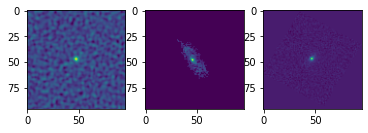

In [9]:
subplot(131)
imshow(a[0][0][3,:,:,0])
subplot(132)
imshow(a[0][1][3,:,:,0])
subplot(133)
imshow(a[1][3,:,:,0])

## Step II: Define a network

In [17]:
# Disclaimer.... this is a very stupod network
inputs = tf.keras.Input(shape=[96, 96, 1],name='input_image')
# window and norm are preprocessed constants that are data dependent. That's why there are given as inputs
window = tf.keras.Input((96, 96,1),name='window')
norm = tf.keras.Input((6,1,1),name='norm')

net = tf.keras.layers.Conv2D(32, 3, padding='same')(inputs)
net = tf.keras.layers.Activation('relu')(net)
net = tf.keras.layers.Conv2D(16, 3, padding='same')(net)

outputs = tf.keras.layers.Conv2D(1, 3, padding='same')(net)

In [20]:
# Define custom loss and metric for a single window shape constraint
# Define constants required for the custom functions
from DeepDeconv.deepnetFCS.DeepNet import makeUi
U = makeUi(96,96)
gamma = 1

def custom_loss(y_true,y_pred):
    residual = y_true-y_pred
    data_fid = tf.keras.backend.mean(tf.keras.backend.square(y_true-y_pred), axis=-1)
    window, mu = model.input[1:]
    shape_constraint=0
    for i in range(6):
        shape_constraint+=gamma*mu[:,i,0,0]*\
        (tf.keras.backend.square(
            (tf.keras.backend.sum((residual)*window*U[i],axis=(1,2,3)))))/2
    shape_constraint/=(96*96)
    shape_constraint=tf.keras.backend.expand_dims((tf.keras.backend.expand_dims(shape_constraint, axis=-1)),axis=-1)
    return data_fid+shape_constraint

def custom_metric(y_true,y_pred):
    residual=y_true-y_pred
    window, mu = model.input[1:]
    shape_constraint=0
    for i in range(6):
        shape_constraint+=gamma*mu[:,i,0,0]*\
        (tf.keras.backend.square(
            (tf.keras.backend.sum(residual*window*U[i],axis=(1,2,3)))))/2 
    shape_constraint/=(96*96)
    shape_constraint=tf.keras.backend.expand_dims((tf.keras.backend.expand_dims(shape_constraint, axis=-1)),axis=-1)
    return shape_constraint

In [21]:
# Compile the model
model = tf.keras.Model(inputs=[inputs,window,norm], outputs=outputs)
model.compile(optimizer = tf.keras.optimizers.Adam(lr=1e-3), loss = custom_loss,
              weighted_metrics=[tf.keras.metrics.mse,custom_metric])

## Step III: Training

In [22]:
# Train the model
history = model.fit_generator(gen, 
                              steps_per_epoch=100,
                              epochs=20)

Epoch 1/20
100/100 [==============================] - 40s 401ms/step - loss: 22.9345 - weighted_mean_squared_error: 7.5910e-04 - weighted_custom_metric: 0.0321
Epoch 2/20
100/100 [==============================] - 17s 167ms/step - loss: 10.0724 - weighted_mean_squared_error: 4.7812e-04 - weighted_custom_metric: 0.0145
Epoch 3/20
100/100 [==============================] - 17s 166ms/step - loss: 6.9418 - weighted_mean_squared_error: 4.0135e-04 - weighted_custom_metric: 0.0095
Epoch 4/20
100/100 [==============================] - 16s 155ms/step - loss: 6.2717 - weighted_mean_squared_error: 4.0563e-04 - weighted_custom_metric: 0.0085
Epoch 5/20
100/100 [==============================] - 15s 155ms/step - loss: 6.6213 - weighted_mean_squared_error: 3.7377e-04 - weighted_custom_metric: 0.0088
Epoch 6/20
100/100 [==============================] - 16s 155ms/step - loss: 5.8618 - weighted_mean_squared_error: 3.6596e-04 - weighted_custom_metric: 0.0077
Epoch 7/20
100/100 [========================

dict_keys(['loss', 'weighted_mean_squared_error', 'weighted_custom_metric'])


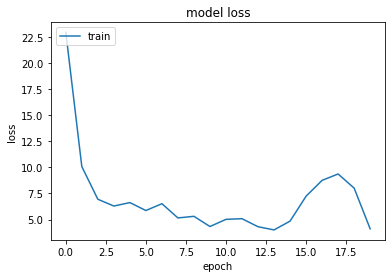

In [24]:
# have a look at history
history
# list all data in history
print(history.history.keys())
# summarize history for loss
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train'], loc='upper left')
plt.show()

## Step IV: Applying the model

In [25]:
test_input = [np.float32(a[0][0]),np.float32(a[0][2]),np.float32(a[0][1])]

In [26]:
# The model can be applied like so:
res = model(test_input)
# This should return the solution of the deconvolution prblm
res_np = tf.keras.backend.eval(res).squeeze(axis=-1) #convert solution to numpy array and remove last dimension

In [27]:
a[0][0].shape

(32, 96, 96, 1)

Text(0.5, 1.0, 'Deconvolved')

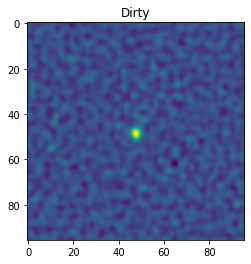

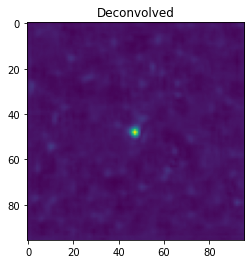

In [28]:
# Show a deconvolved image
figure()
imshow(a[0][0][0].squeeze(axis=-1))
title('Dirty')
figure()
imshow(res_np[0])
title('Deconvolved')